In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.io import FortranFile
import glob
import ipywidgets as widgets
import MIMutils

%matplotlib inline

# Examples for reduced gravity model

This notebook contains several example runs of a reduced gravity model with n + 1/2 layers. They're in separate folders. Any line of code that starts with an exclamation mark (!) is executed by the terminal, not the python kernel.

## Hints
* The size of the grid (nx,ny,layers) must be specified when the code is compiled. Everything else is specified in parameters.in and can be varied at runtime. This means that the same binary file can be used to perform multiple simulations.
* Axis order is z,y,x

## f-plane at rest


Boring simulation, but shows that the model is stable.

Let's use:
* nx = 100
* ny = 100
* layers = 1

In [2]:
os.chdir('reduced_gravity/f_plane/')

In [3]:
grid = MIMutils.Grid(100,100,2e4,2e4)

In [4]:
os.chdir('input/')

fu = np.ones((100,101), dtype=np.float64)*10e-4
fv = np.ones((101,100), dtype=np.float64)*10e-4

f = FortranFile('fu.bin', 'w')
f.write_record(fv)
f.close()

f = FortranFile('fv.bin', 'w')
f.write_record(fv)
f.close()

wetmask = np.ones((100,100), dtype=np.float64)
wetmask[0,:] = 0
wetmask[-1,:] = 0
wetmask[:,0] = 0
wetmask[:,-1] = 0

f = FortranFile('wetmask.bin', 'w')
f.write_record(wetmask)
f.close()

initH = np.ones((100,100), dtype=np.float64)*400

f = FortranFile('initH.bin', 'w')
f.write_record(initH)
f.close()

os.chdir('../')

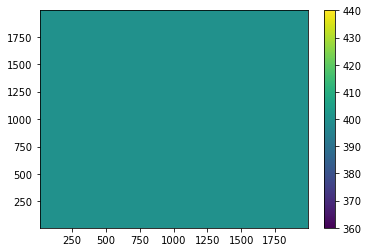

In [6]:
f = FortranFile('output/snap.h.0000000001')
h_init = f.read_record(dtype=np.float64).reshape(100,100,1)
f.close()

f = FortranFile('output/snap.h.0000010001')
h_final = f.read_record(dtype=np.float64).reshape(100,100,1)
f.close()

plt.pcolormesh(grid.x/1e3,grid.y/1e3,h_final[:,:,0])
plt.colorbar()

In [7]:
os.chdir('../')

### $\beta $-plane with a Gaussian bump 

Slightly more exciting. Initialise a bump in the thickness field on a $\beta $-plane and let it go.

Let's use:
* nx = 100
* ny = 100
* layers = 1
* dx = 1e4
* dy = 1e4

In [8]:
os.chdir('beta_plane_bump/')

In [9]:
os.chdir('input/')

In [10]:
grid = MIMutils.Grid(100,100,1e4,1e4)

f0 = 1e-5
beta = 2e-11

X,Y = np.meshgrid(grid.xp1,grid.y)
fu = f0 + Y*beta
X,Y = np.meshgrid(grid.x,grid.yp1)
fv = f0 + Y*beta

f = FortranFile('fu.bin', 'w')
f.write_record(fu.astype(np.float64))
f.close()

f = FortranFile('fv.bin', 'w')
f.write_record(fv.astype(np.float64))
f.close()

wetmask = np.ones((100,100), dtype=np.float64)
wetmask[0,:] = 0
wetmask[-1,:] = 0
wetmask[:,0] = 0
wetmask[:,-1] = 0

f = FortranFile('wetmask.bin', 'w')
f.write_record(wetmask.astype(np.float64))
f.close()

X,Y = np.meshgrid(grid.x,grid.y)

initH = 500 + 20*np.exp(-((6e5-X)**2 + (5e5-Y)**2)/(2*1e5**2))

f = FortranFile('initH.bin', 'w')
f.write_record(initH.astype(np.float64))
f.close()

In [11]:
os.chdir('../')

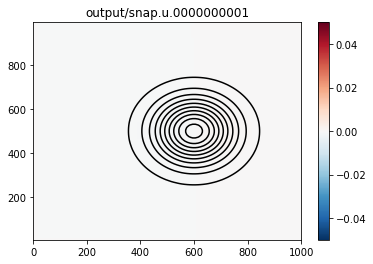

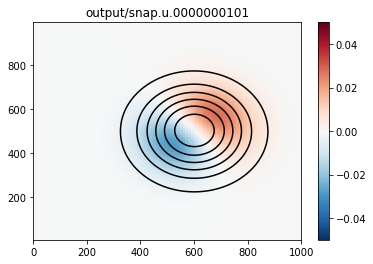

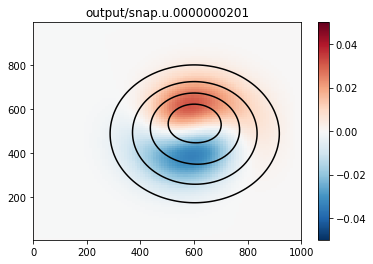

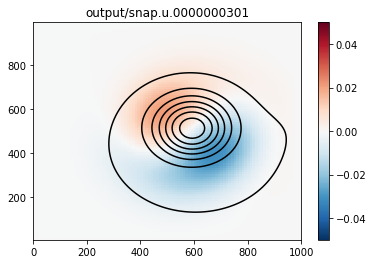

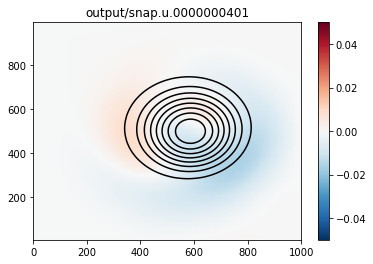

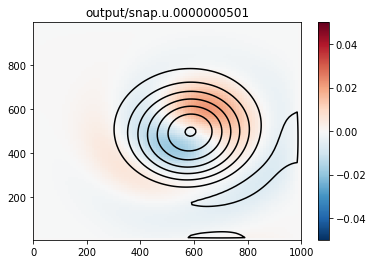

In [12]:
u_files = sorted(glob.glob('output/snap.u.*'))
h_files = sorted(glob.glob('output/snap.h.*'))

X_u,Y_u = np.meshgrid(grid.xp1,grid.y)
X_h,Y_h = np.meshgrid(grid.x,grid.y)

for counter,udata_file in enumerate(u_files):
    f = FortranFile(udata_file)
    u = f.read_record(dtype=np.float64).reshape(1,100,101)
    f.close()
    
    f = FortranFile(h_files[counter])
    h = f.read_record(dtype=np.float64).reshape(1,100,100)
    f.close()
    
    plt.figure()
    plt.title(udata_file)
    plt.pcolormesh(X_u/1e3,Y_u/1e3,u[0,:-1,:],vmin=-.05,vmax=.05,cmap='RdBu_r')
    plt.colorbar()
    plt.contour(X_h/1e3,Y_h/1e3,h[0,:,:],np.arange(489,520,2),colors='k')
    #plt.xlim(0,50)


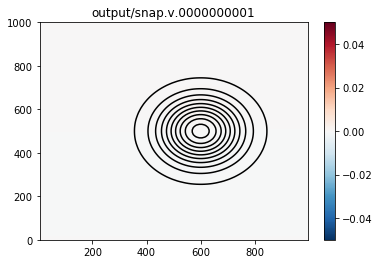

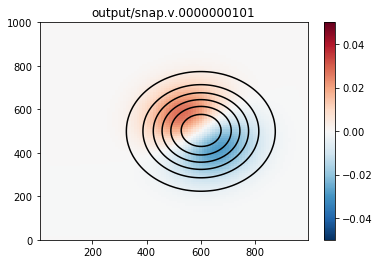

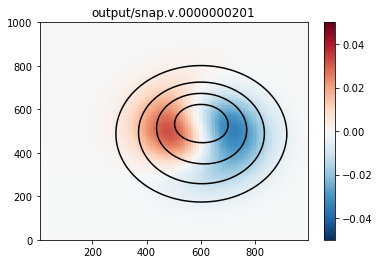

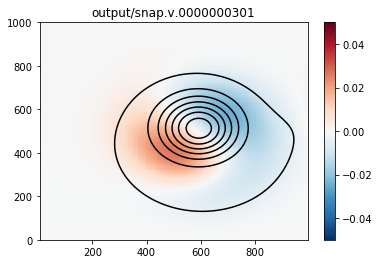

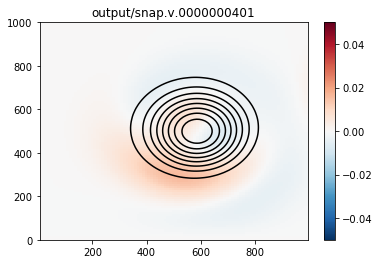

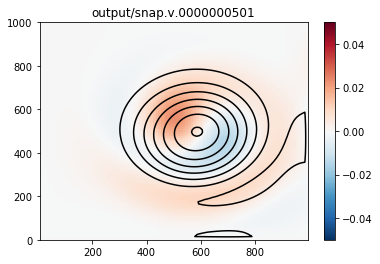

In [13]:
v_files = sorted(glob.glob('output/snap.v.*'))

X_v,Y_v = np.meshgrid(grid.x,grid.yp1)
X_h,Y_h = np.meshgrid(grid.x,grid.y)

for counter,vdata_file in enumerate(v_files):
    f = FortranFile(vdata_file)
    v = f.read_record(dtype=np.float64).reshape(1,101,100)
    f.close()
    
    f = FortranFile(h_files[counter])
    h = f.read_record(dtype=np.float64).reshape(1,100,100)
    f.close()
    
    plt.figure()
    plt.title(vdata_file)
    plt.pcolormesh(X_v/1e3,Y_v/1e3,v[0,:,:-1],vmin=-.05,vmax=.05,cmap='RdBu_r')
    plt.colorbar()
    plt.contour(X_h/1e3,Y_h/1e3,h[0,:,:],np.arange(489,520,2),colors='k')


In [14]:
os.chdir('../')

# Twin-gyre on a $\beta$-plane domain with boundary conditions

This time we'll add some wind forcing and play with the boundary condition. This shows how the same compiled file can be used for different simulations. We change the value of 'slip' in parameters.in and rerun the model.

Let's use:
* nx = 100
* ny = 200
* layers = 1
* dx = 1e4
* dy = 1e4

In [15]:
os.chdir('beta_plane_gyre/')

In [16]:
os.chdir('input/')

In [17]:
nx = 100
ny = 200
layers = 1
dx = 1e4
dy = 1e4

grid = MIMutils.Grid(nx,ny,dx,dy)

f0 = 1e-5
beta = 2e-11

X,Y = np.meshgrid(grid.xp1,grid.y)
fu = f0 + Y*beta
X,Y = np.meshgrid(grid.x,grid.yp1)
fv = f0 + Y*beta

f = FortranFile('fu.bin', 'w')
f.write_record(fu.astype(np.float64))
f.close()

f = FortranFile('fv.bin', 'w')
f.write_record(fv.astype(np.float64))
f.close()

wetmask = np.ones((ny,nx), dtype=np.float64)
wetmask[0,:] = 0
wetmask[-1,:] = 0
wetmask[:,0] = 0
wetmask[:,-1] = 0

#wetmask[np.sin(np.pi*Y/2e6)]

f = FortranFile('wetmask.bin', 'w')
f.write_record(wetmask.astype(np.float64))
f.close()

X,Y = np.meshgrid(grid.x,grid.y)

initH = 400 + 0*np.exp(-((6e5-X)**2 + (5e5-Y)**2)/(2*1e5**2))

f = FortranFile('initH.bin', 'w')
f.write_record(initH.astype(np.float64))
f.close()

X,Y = np.meshgrid(grid.xp1,grid.y)
wind_x = 0.05*(1-np.cos(2*np.pi*Y/np.max(grid.y)))
f = FortranFile('wind_x.bin', 'w')
f.write_record(wind_x.astype(np.float64))
f.close()

In [18]:
print wind_x.shape

(200, 101)


In [19]:
os.chdir('../')

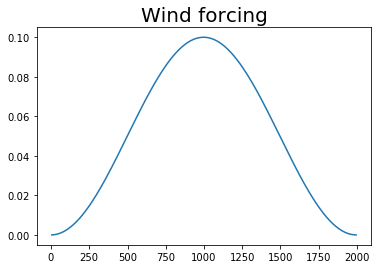

In [20]:
plt.plot(grid.y/1e3,wind_x[:,10])
plt.title('Wind forcing',fontsize=20);

## Free-slip

In [21]:
os.chdir('free_slip/')

In [ ]:
u_files = sorted(glob.glob('output/snap.u.*'))
u_files.pop(0)
h_files = sorted(glob.glob('output/snap.h.*'))
h_files.pop(0)

X_u,Y_u = np.meshgrid(grid.xp1,grid.y)
X_h,Y_h = np.meshgrid(grid.x,grid.y)

for counter,udata_file in enumerate(u_files):
    
    f = FortranFile(h_files[counter], mode = 'r')
    h = f.read_reals('d')
    #read_record(dtype=np.float64)
    h = h.reshape(layers, ny, nx)
#     h = np.transpose(h,(2,1,0)) # make it h[nx,ny,layers]
    f.close()
    
    f = FortranFile(udata_file,mode = 'r')
    u = f.read_reals('d')
    #read_record(dtype=np.float64)
    u = u.reshape(layers,ny,nx+1)
#     u = np.transpose(u,(2,1,0))
    
    plt.figure()
    plt.axes().set_aspect('equal', 'datalim')
    plt.title(udata_file)
    plt.pcolormesh(X_u/1e3,Y_u/1e3,(u[0,:,:]),vmin=-.1,vmax=.1,cmap='RdBu_r')
    plt.colorbar()
    plt.contour(X_h/1e3,Y_h/1e3,(h[0,:,:]),np.arange(100,800,1),colors='k',alpha=0.6)


In [ ]:
os.chdir('../')

## No slip

In [ ]:
os.chdir('no_slip/')

In [ ]:
u_files = sorted(glob.glob('output/snap.u.*'))
u_files.pop(0)
h_files = sorted(glob.glob('output/snap.h.*'))
h_files.pop(0)

X_u,Y_u = np.meshgrid(grid.xp1,grid.y)
X_h,Y_h = np.meshgrid(grid.x,grid.y)

for counter,udata_file in enumerate(u_files):
    
    f = FortranFile(h_files[counter], mode = 'r')
    h = f.read_reals('d')
    #read_record(dtype=np.float64)
    h = h.reshape(layers, ny, nx)
#     h = np.transpose(h,(2,1,0)) # make it h[nx,ny,layers]
    f.close()
    
    f = FortranFile(udata_file,mode = 'r')
    u = f.read_reals('d')
    #read_record(dtype=np.float64)
    u = u.reshape(layers,ny,nx+1)
#     u = np.transpose(u,(2,1,0))
    
    plt.figure()
    plt.axes().set_aspect('equal', 'datalim')
    plt.title(udata_file)
    plt.pcolormesh(X_u/1e3,Y_u/1e3,(u[0,:,:]),vmin=-.1,vmax=.1,cmap='RdBu_r')
    plt.colorbar()
    plt.contour(X_h/1e3,Y_h/1e3,(h[0,:,:]),np.arange(100,800,1),colors='k',alpha=0.6)


In [ ]:
os.chdir('../')